# Fine-Tuning YOLOv5 on a Multi-Class Vehicle Detection Dataset

This project focuses on fine-tuning the YOLOv5 object detection model on the [Vehicle Dataset for YOLO](https://www.kaggle.com/datasets/nadinpethiyagoda/vehicle-dataset-for-yolo/data?select=vehicle+dataset), which contains 3,000 annotated images across six vehicle classes: Car, Threewheel, Bus, Truck, Motorbike, and Van. The dataset provides labeled bounding boxes in YOLO format and features a variety of real-world driving scenes.
Using the YOLOv5n (Nano) model from the official [Ultralytics repository](https://github.com/ultralytics/yolov5), we fine-tuned the model to work effectively on this dataset, using Google Colab environment with T4 GPUs. Evaluation metrics include mean Average Precision (mAP), precision, and recall.


In [ ]:
!pip install ultralytics
from ultralytics import YOLO
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Image as IPyImage, display
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image
import numpy as np
from matplotlib.lines import Line2D

## Dataset Configuration for YOLOv5

We first set up the required `data.yaml` file for training a YOLOv5 object detection model using a the vehicle dataset. The YAML file specifies the structure of the dataset — paths to training and validation images — and defines the object classes present in the dataset.
It specifically includes 6 vehicle categories: Car, Threewheel, Bus, Truck, Motorbike, and Van. This setup informs the YOLOv5 model of the number of classes and where to locate the input data.


In [9]:
# The root directory where the YOLO dataset is stored
dataset_path = '/content/drive/MyDrive/YOLO'

# The YAML configuration content for YOLOv5 training
# This defines the dataset structure and the object classes
yaml_content = f"""
path: {dataset_path}                 # Root directory of the dataset
train: train/images                  # Relative path to training images
val: valid/images                    # Relative path to validation images

nc: 6                                # Number of object classes
names: ['Car', 'Threewheel', 'Bus', 'Truck', 'Motorbike', 'Van']  # Class labels
"""

# Write the YAML configuration to 'data.yaml'
data_yaml_path = f'{dataset_path}/data.yaml'
with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

## Fine-Tuning YOLOv8 on the Given Vehicle Dataset

We use the pre-trained YOLOv8n model, initialized with weights from the COCO dataset, to fine-tune on our custom vehicle dataset. YOLOv8n is the nano version — optimized for speed and lightweight environments like Google Colab. For higher accuracy at the cost of computation, larger variants such as `yolov8s.pt` or `yolov8m.pt` can be used.
Training is performed using the Ultralytics API.

In [ ]:
# Load a pre-trained YOLOv8n model with COCO weights
model = YOLO('yolov8n.pt')

# Fine-tune the model on the vehicle dataset
model.train(
    data=data_yaml_path,   # Path to the dataset configuration file (data.yaml)
    epochs=50,             # Number of training epochs
    imgsz=640,              # Input image size
    project="/content/drive/MyDrive/YOLO",
    name="vehicle-finetune"
)

## YOLOv8 Training Metrics Overview

The training and validation curves below illustrate the model's performance over 50 epochs. Each subplot tracks a key metric used to evaluate the learning progress and detection quality.

| Metric                    | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `train/box_loss`          | Bounding box regression loss on the training set. Lower = better fit.       |
| `train/cls_loss`          | Classification loss on the training set. Measures label prediction errors.  |
| `train/dfl_loss`          | Distribution Focal Loss (YOLOv8). Enhances localization accuracy.           |
| `val/box_loss`            | Bounding box regression loss on the validation set.                         |
| `val/cls_loss`            | Classification loss on the validation set.                                  |
| `val/dfl_loss`            | Distribution Focal Loss on validation.                                      |
| `metrics/precision(B)`    | Precision on validation: % of predicted boxes that are correct.             |
| `metrics/recall(B)`       | Recall on validation: % of actual objects correctly detected.               |
| `metrics/mAP50(B)`        | Mean Average Precision at IoU=0.50.  |
| `metrics/mAP50-95(B)`     | Mean Average Precision averaged over IoU=0.50 to 0.95 (step=0.05). Stricter. |

### Observations

- **Loss Curves (Top Left 3 + Bottom Left 3)**:  
  All loss metrics (box, class, DFL) show a consistent downward trend for both training and validation.

- **Precision & Recall**:  
  Steady increases in both precision and recall suggest that the model is improving in detecting the correct objects and minimizing false positives/negatives.

- **mAP50 & mAP50-95**:  
  The mAP scores increase significantly over epochs, reaching above 0.95 for `mAP50` and around 0.90 for `mAP50-95`, indicating strong detection performance across a range of IoU thresholds.

These metrics collectively suggest the model has fine-tuned well on the vehicle dataset with high localization and classification accuracy.


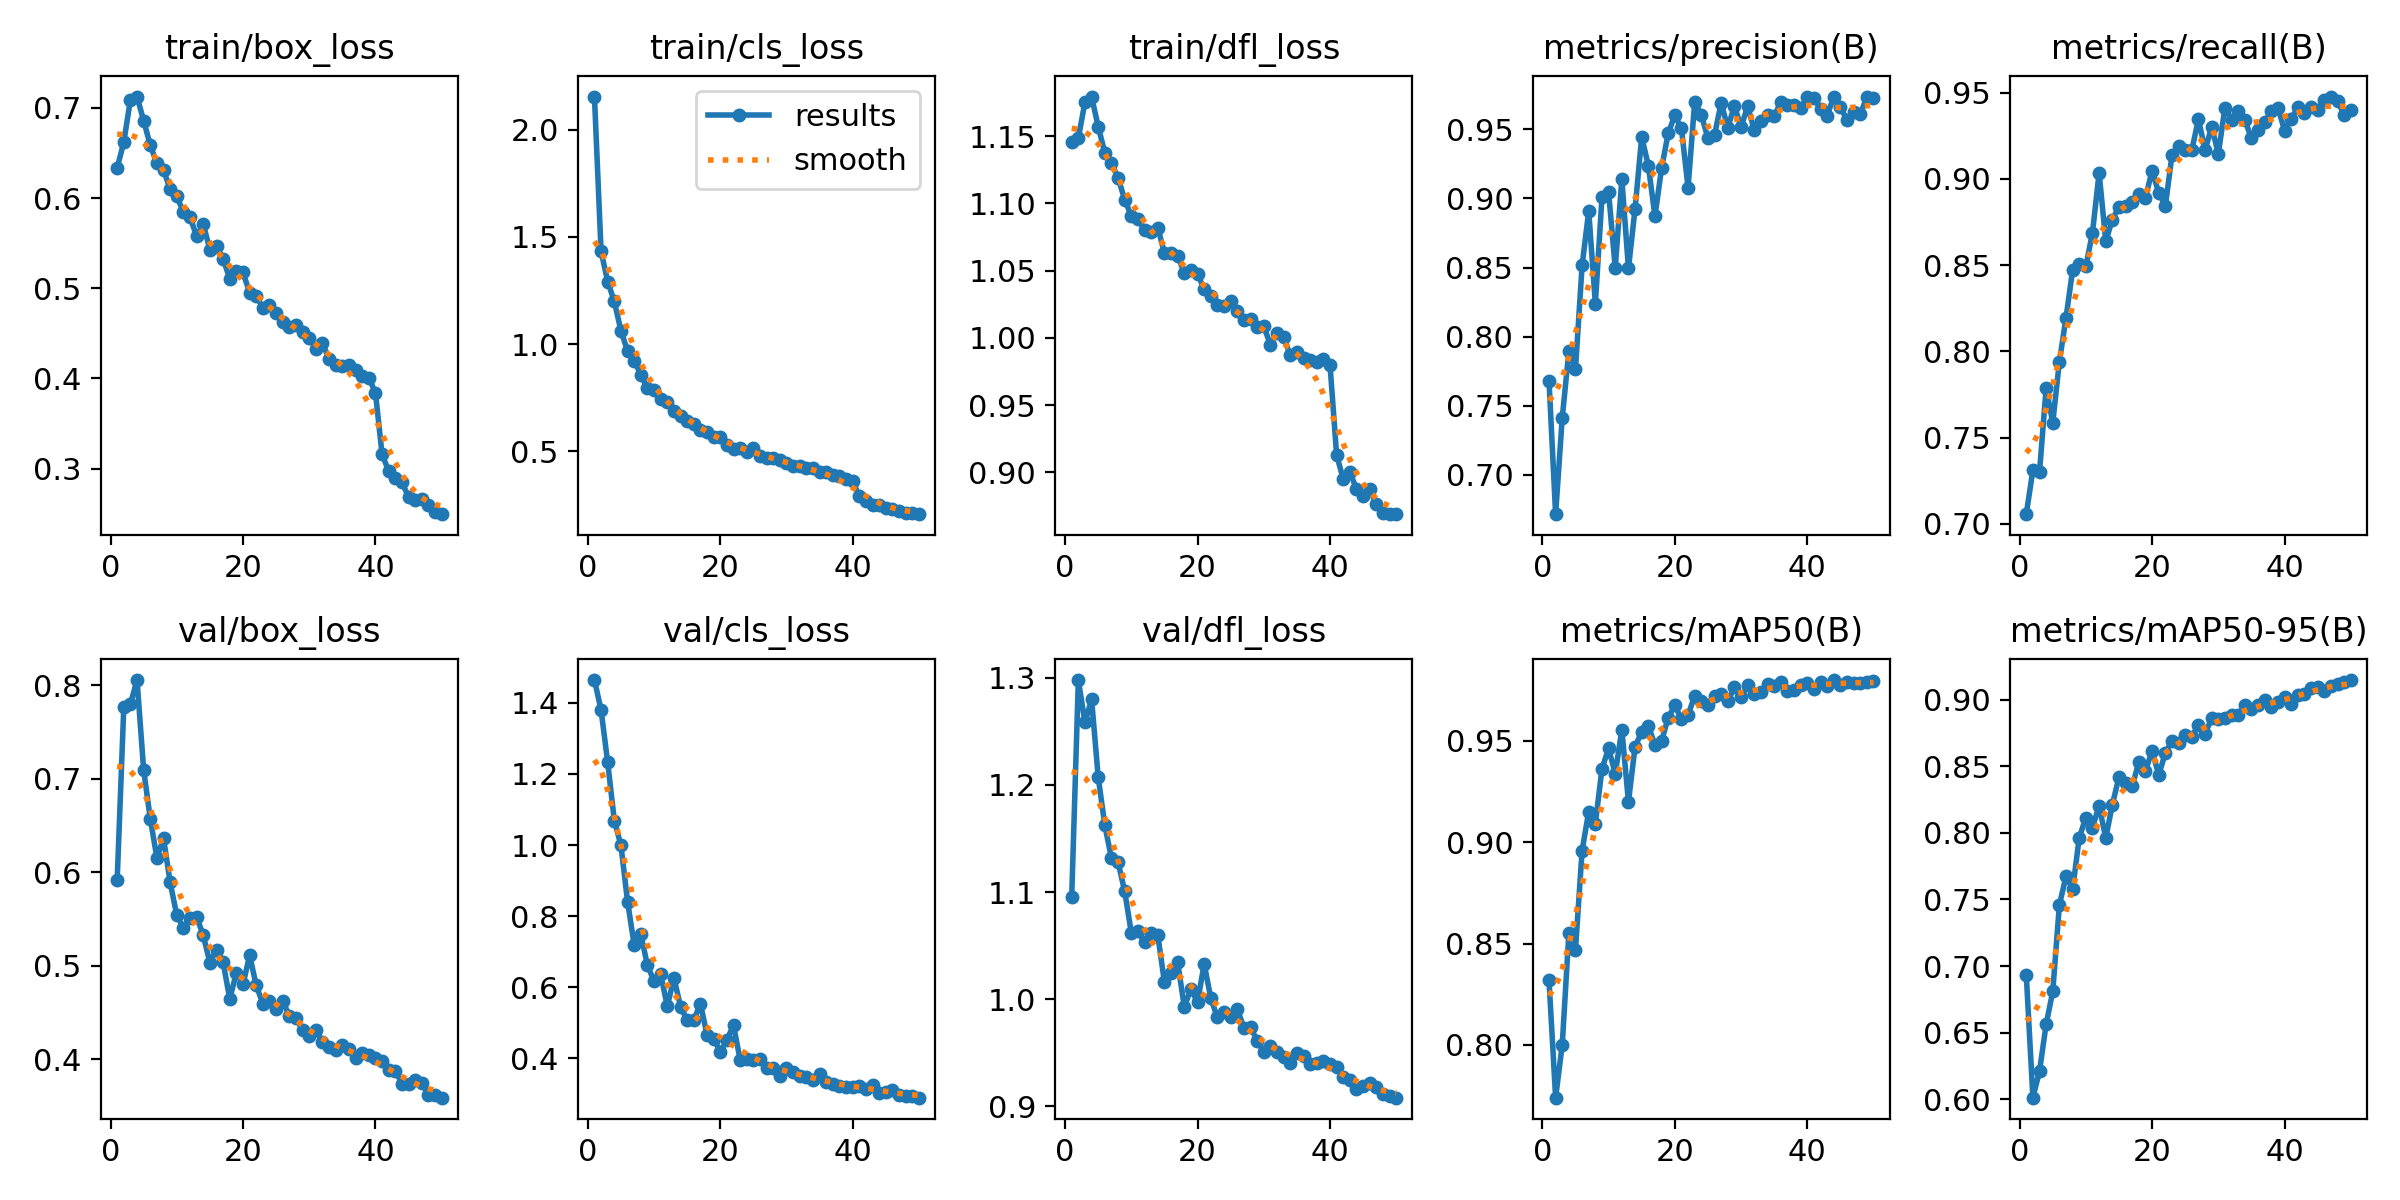

In [24]:
# The base directory where YOLOv8 training outputs are stored
results_path = '/content/drive/MyDrive/YOLO/vehicle-finetune/results.png'
display(IPyImage(filename=results_path, width=1000))

## Object Detection Visualization

The figure generated below presents a qualitative evaluation of a fine-tuned **YOLOv8** model on the custom 6-class vehicle dataset.
For each class, one validation image was selected to visualize both **ground truth annotations** and **model predictions**. The model achieves high IoU (> 0.85) for most classes, indicating strong alignment with ground truth and the visualization shows that the model generalizes well across all vehicle types.

### Annotation Guide:
-  **Green boxes** represent ground truth annotations.
-  **Red boxes** represent YOLOv8 predictions.
- Prediction labels include:
  - **Class name**
  - **Confidence score**
  - **IoU** with the best-matching ground truth box.


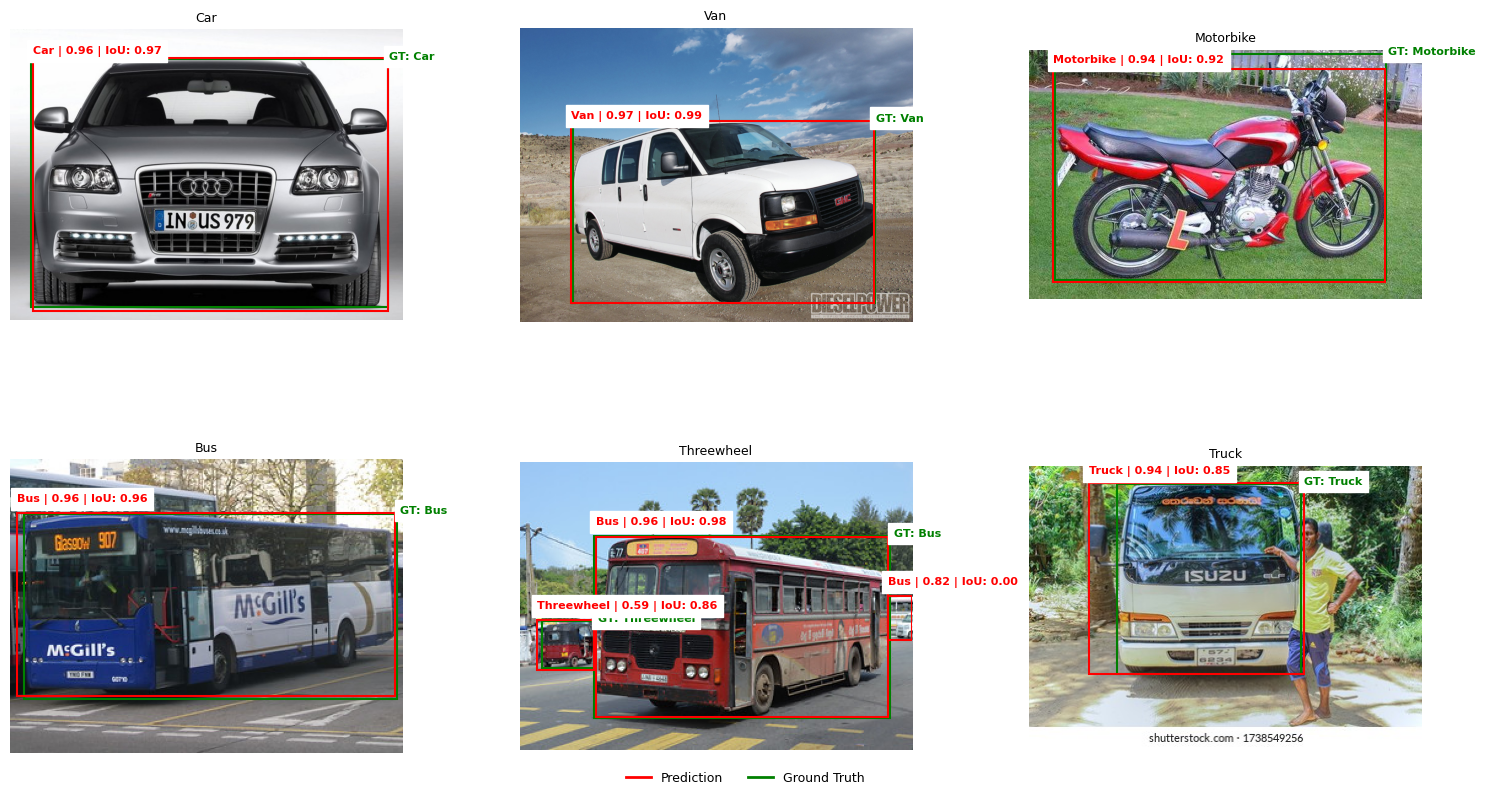

In [28]:
# ------------------- Configuration -------------------

model_path = '/content/drive/MyDrive/YOLO/vehicle-finetune/weights/best.pt'
image_folder = Path('/content/drive/MyDrive/YOLO/valid/images')
label_folder = Path('/content/drive/MyDrive/YOLO/valid/labels')
class_names = ['Car', 'Threewheel', 'Bus', 'Truck', 'Motorbike', 'Van']
model = YOLO(model_path)

# ------------------- Helper Functions -------------------

def yolo_to_xyxy(yolo_box, img_w, img_h):
    cls, cx, cy, w, h = yolo_box
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return int(cls), [x1, y1, x2, y2]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = boxA_area + boxB_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# ------------------- Select One Image per Class -------------------

# Iterate through all label files and collect one image per class
class_to_image = {}
for label_path in sorted(label_folder.glob('*.txt')):
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        cls_id = int(line.strip().split()[0])
        if cls_id not in class_to_image:
            img_path = image_folder / label_path.with_suffix('.jpg').name
            if img_path.exists():
                class_to_image[cls_id] = img_path
            break

    if len(class_to_image) == len(class_names):
        break  # Stop if we have one image per class

# ------------------- Visualize -------------------
# Set layout configuration
images = list(class_to_image.items())
n_cols = 3
n_rows = int(np.ceil(len(images) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axs = axs.flatten()

# Define drawing styles
fontsize = 8
linewidth = 1.5

for idx, (cls_id, img_path) in enumerate(images):
    ax = axs[idx]

    # Load and convert image
    img = Image.open(img_path).convert("RGB")
    img_w, img_h = img.size
    image_np = np.array(img)

    # Load ground truth boxes
    gt_boxes = []
    label_path = label_folder / img_path.with_suffix('.txt').name
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                yolo_vals = list(map(float, line.strip().split()))
                cls_gt, box = yolo_to_xyxy(yolo_vals, img_w, img_h)
                gt_boxes.append((cls_gt, box))

    # Run inference (suppress logging)
    result = model(img_path, verbose=False)[0]
    pred_boxes = result.boxes.xyxy.cpu().numpy()
    pred_scores = result.boxes.conf.cpu().numpy()
    pred_classes = result.boxes.cls.cpu().numpy().astype(int)

    # Show image
    ax.imshow(image_np)
    short_name = img_path.name[:30]  # truncate long filenames
    ax.set_title(f"{class_names[cls_id]}", fontsize=9)
    ax.axis('off')

    # Draw ground truth boxes
    for cls_gt, box in gt_boxes:
        ax.add_patch(patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0], box[3] - box[1],
            linewidth=linewidth, edgecolor='green', facecolor='none'
        ))
        ax.text(box[2] + 3, box[1],
                f"GT: {class_names[cls_gt]}",
                color='green', fontsize=fontsize, backgroundcolor='white', weight='bold')


    # Draw predicted boxes with IoU
    for box, score, pred_cls in zip(pred_boxes, pred_scores, pred_classes):
        # Compute best IoU with matching ground truth class
        best_iou = 0
        for gt_cls, gt_box in gt_boxes:
            if gt_cls == pred_cls:
                iou = compute_iou(box, gt_box)
                best_iou = max(best_iou, iou)

        ax.add_patch(patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0], box[3] - box[1],
            linewidth=linewidth, edgecolor='red', facecolor='none'
        ))
        ax.text(box[0], box[1] - 10,
                f"{class_names[pred_cls]} | {score:.2f} | IoU: {best_iou:.2f}",
                color='red', fontsize=fontsize, backgroundcolor='white', weight='bold')


plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Prediction'),
    Line2D([0], [0], color='green', lw=2, label='Ground Truth')
]
fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=2,
           fontsize=9,
           frameon=False,
           bbox_to_anchor=(0.5, -0.01));

